In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("users-score-2023.csv",usecols=['user_id','anime_id','rating'])

In [3]:
df.shape

(24325191, 3)

In [4]:
df.head()

,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [5]:
df[df['rating']==0]

,user_id,anime_id,rating


In [6]:
df[df.duplicated()]

,user_id,anime_id,rating


In [8]:
scaler=MinMaxScaler()
df['scaled_rating']=scaler.fit_transform(df[['rating']])

In [9]:
df.head()

,user_id,anime_id,rating,scaled_rating
0,1,21,9,0.888889
1,1,48,7,0.666667
2,1,320,5,0.444444
3,1,49,8,0.777778
4,1,304,8,0.777778


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

In [11]:
user_encoder=LabelEncoder()
df["user_encoded"]=user_encoder.fit_transform(df["user_id"])
num_users=len(user_encoder.classes_)
anime_encoder=LabelEncoder()
df["anime_encoded"]=anime_encoder.fit_transform(df["anime_id"])
num_animes=len(anime_encoder.classes_)
num_users,num_animes

(270033, 16500)

In [12]:
max(df['user_id']), max(df['anime_id'])

(1291097, 56085)

In [13]:
max(df['user_encoded']), max(df['anime_encoded'])

(270032, 16499)

In [14]:
df.head()

,user_id,anime_id,rating,scaled_rating,user_encoded,anime_encoded
0,1,21,9,0.888889,0,11
1,1,48,7,0.666667,0,29
2,1,320,5,0.444444,0,296
3,1,49,8,0.777778,0,30
4,1,304,8,0.777778,0,280


In [15]:
X=df[['user_encoded','anime_encoded']].values
y=df['scaled_rating'].values

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=73)
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Creating a deep neural network to adjust the weights between user-item and item-item similarity for weight calculation and evaluation of similar users and items 

In [18]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    user=Input(shape=[1])
    user_embedding=Embedding(input_dim=num_users, output_dim=embedding_size)(user)
    
    anime=Input(shape=[1])
    anime_embedding=Embedding(input_dim=num_animes, output_dim=embedding_size)(anime)
    
    dot_product=Dot(normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened=Flatten()(dot_product)
    
    dense=Dense(64, activation='relu')(flattened)
    output=Dense(1, activation='sigmoid')(dense)
    
    model=Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae","mse"])
    return model

In [19]:
model=RecommenderNet(num_users, num_animes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 128)            │      34,564,224 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 1, 128)            │       2,112,000 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dot (Dot)                     │ (None, 1, 1)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 1)                 │               0 │ dot[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │             128 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │              65 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 36,676,417 (139.91 MB)

 Trainable params: 36,676,417 (139.91 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [21]:
start_lr=0.00001
min_lr=0.00001
max_lr=0.00005
batch_size=10000

rampup_epochs=5
sustain_epochs=0
exp_decay=0.8

In [22]:
def lrfn(epoch):
    if epoch<rampup_epochs:
        return (max_lr-start_lr)/rampup_epochs*epoch+start_lr
    elif epoch<rampup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr)*exp_decay**(epoch-rampup_epochs-sustain_epochs)+min_lr

In [23]:
lr_callback=LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

In [24]:
checkpoint_filepath='myanime.weights.h5'
model_checkpoints=ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

In [25]:
early_stopping=EarlyStopping(patience=3,monitor='val_loss',mode='min',restore_best_weights=True)

In [26]:
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [27]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)
model.load_weights(checkpoint_filepath)

Epoch 1/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 831s 340ms/step - loss: 0.6837 - mae: 0.2551 - mse: 0.0850 - val_loss: 0.6561 - val_mae: 0.2289 - val_mse: 0.0712 - learning_rate: 1.0000e-05
Epoch 2/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 804s 329ms/step - loss: 0.6400 - mae: 0.2135 - mse: 0.0633 - val_loss: 0.5992 - val_mae: 0.1715 - val_mse: 0.0437 - learning_rate: 1.8000e-05
Epoch 3/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 796s 326ms/step - loss: 0.5895 - mae: 0.1593 - mse: 0.0393 - val_loss: 0.5775 - val_mae: 0.1472 - val_mse: 0.0341 - learning_rate: 2.6000e-05
Epoch 4/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 803s 328ms/step - loss: 0.5772 - mae: 0.1466 - mse: 0.0340 - val_loss: 0.5773 - val_mae: 0.1458 - val_mse: 0.0340 - learning_rate: 3.4000e-05
Epoch 5/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 830s 339ms/step - loss: 0.5736 - mae: 0.1418 - mse: 0.0327 - val_loss: 0.5629 - val_mae: 0.1306 - val_mse: 0.0286 - learning_rate: 4.2000e-05
Epoch 6/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 828s 338ms/step - loss: 0.5511 - mae: 

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Analysing Loss metrics evaluation of model creation

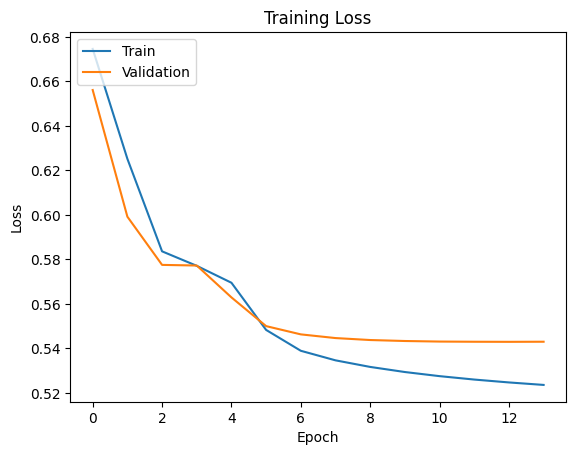

In [29]:
plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [30]:
import numpy as np
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights=weight_layer.get_weights()[0]
    weights=weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

In [31]:
anime_weights=extract_weights('embedding_1', model)
user_weights=extract_weights('embedding', model)

In [32]:
anime_weights,user_weights

(array([[-0.01681563, -0.08661497, -0.05198155, ..., -0.03423922,
         -0.08258127,  0.02065872],
        [-0.02282816, -0.12495351, -0.08732692, ..., -0.0080976 ,
         -0.03612326, -0.02875917],
        [-0.00948909, -0.12068405,  0.03642132, ..., -0.06998159,
         -0.00575439, -0.06128949],
        ...,
        [-0.10075024, -0.10842944, -0.01804586, ...,  0.1241356 ,
          0.01179261,  0.14276253],
        [-0.12939668, -0.11692025,  0.08185726, ..., -0.08733377,
         -0.10588397,  0.00377991],
        [ 0.10651202,  0.09925623,  0.04445078, ..., -0.0962816 ,
          0.0980167 ,  0.07634337]], dtype=float32),
 array([[ 0.1431482 ,  0.10961989, -0.03168798, ..., -0.02238314,
         -0.05890398, -0.02132849],
        [ 0.09136371, -0.00237033, -0.162587  , ..., -0.04132   ,
          0.14202614, -0.11903473],
        [ 0.12029241,  0.03072744,  0.03825082, ..., -0.16920765,
         -0.09793384,  0.06268204],
        ...,
        [-0.03688686,  0.04893098, -0.0

In [100]:
import pandas as pd
import pickle

with open("anime-dataset.pkl", "rb") as file:
    df_anime = pickle.load(file)

df_anime.head()

,anime_id,Name,English name,Score,Genres,Synopsis,Type,Status,Producers,Licensors,...,Source,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL,Start_Year,End_Year
0,1,Cowboy Bebop,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,Finished Airing,Bandai Visual,"Funimation, Bandai Entertainment",...,Original,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,1998,1999
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,Finished Airing,"Sunrise, Bandai Visual",Sony Pictures Entertainment,...,Original,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...,2001,2001
2,6,Trigun,Trigun,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,Finished Airing,Victor Entertainment,"Funimation, Geneon Entertainment USA",...,Manga,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...,1998,1998
3,7,Witch Hunter Robin,Witch Hunter Robin,7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,Finished Airing,"Bandai Visual, Dentsu, Victor Entertainment, T...","Funimation, Bandai Entertainment",...,Original,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...,2002,2002
4,8,Bouken Ou Beet,Beet the Vandel Buster,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,Finished Airing,"TV Tokyo, Dentsu",Illumitoon Entertainment,...,Manga,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...,2004,2005


In [101]:
df_anime[df_anime['Members']>1000].shape

(12638, 21)

In [102]:
threshold=1000
df_anime= df_anime.query('Members>=@threshold')
df_anime.shape

(12638, 21)

In [103]:
anime_row=df_anime[df_anime['Name'] == 'Naruto'].iloc[0]
idx=anime_row['anime_id']
encoded_idx=anime_encoder.transform([idx])[0]
weights=anime_weights
dist=np.dot(weights,weights[encoded_idx])
sorted_dist=np.argsort(dist)
sorted_dist

array([ 4176, 11459,  8594, ...,   245,  1574,    10], dtype=int64)

## Implementing item-item collaborative filtering based on the weights calculated on the basis of our model and previous user ratings
#### Taking in account to find the cosine similarity of two animes and the higher the similar score, they are recommended on the top as compared to the others

In [138]:
def item_item_collaborative_filtering(name, n, return_dist=False, neg=False):
    try:
        anime_row=df_anime[df_anime['Name'] == name].iloc[0]
        idx=anime_row['anime_id']
        encoded_idx=anime_encoder.transform([idx])[0]
        weights=anime_weights
        dist=np.dot(weights,weights[encoded_idx]) # cosine similarity
        sorted_dist=np.argsort(dist)
        n=n+1
        if neg:
            similar=sorted_dist[:n]
        else:
            similar=sorted_dist[-n:]
        if return_dist:
            return dist,similar
        sim_arr=[]
        for sim in similar:
            decoded_id=anime_encoder.inverse_transform([sim])[0]
            anime_frame=df_anime[df_anime['anime_id']==decoded_id]
            anime_id=anime_frame['anime_id'].values[0]
            anime_name=anime_frame['Name'].values[0]
            english_name=anime_frame['English name'].values[0]
            name=english_name if english_name!="UNKNOWN" else anime_name
            similarity=dist[sim]
            similarity="{:.2f}%".format(similarity*100)
            sim_arr.append({"anime_id":anime_id,"Name":name,"Similarity":similarity})
        sim_df=pd.DataFrame(sim_arr).sort_values(by="Similarity",ascending=False)
        return sim_df[sim_df.Name!=name]['anime_id']
    except:
        print('{} not found in Anime list'.format(name))

In [105]:
item_item_collaborative_filtering('Naruto',n=20,neg=False)

19     1735
18      269
17     6702
16     4437
15     2472
14     2889
13    22043
12     6325
11     1604
10      442
9        21
8      8247
7      1686
6       249
5      1482
4       813
3      8246
2       936
1       594
0      4835
Name: anime_id, dtype: int64

## Implementing user-user collaborative which will take into account the ratings of the anime he has currently rated and map it to a similar most likely user in the existing database and then suggest the anime highly rate by the similar user to our current user which he has not watched yet

In [106]:
def user_user_collaborative_filtering(item_input,n=20,return_dist=False,neg=False):
    try:
        idx=item_input
        encoded_idx=user_encoder.transform([idx])[0]
        weights=user_weights
        dist=np.dot(weights, weights[encoded_idx])
        sorted_dist=np.argsort(dist)
        n=n+1
        if neg:
            similar=sorted_dist[:n]
        else:
            similar=sorted_dist[-n:]    
        sim_arr=[]
        for sim in similar:
            similarity=dist[sim]
            if isinstance(item_input,int):
                decoded_id=user_encoder.inverse_transform([sim])[0]
                sim_arr.append({"similar_users":decoded_id,"similarity":similarity})
        sim_df=pd.DataFrame(sim_arr).sort_values(by="similarity",ascending=False)
        return sim_df
    except:
        print('\033[1m{}\033[0m, Not Found in User list'.format(item_input))

In [107]:
ratings_per_user=df.groupby('user_id').size()
random_user=int(ratings_per_user[ratings_per_user<500].sample(1,random_state=None).index[0])

similar_users=user_user_collaborative_filtering(random_user,n=20,neg=False)
similar_users=similar_users[similar_users['similarity']>0.4]

similar_users=similar_users[similar_users.similar_users!=random_user]
similar_users

,similar_users,similarity


In [108]:
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

## Analysing the preferences of a user based on his past viewing history

In [109]:
def get_user_preferences(user_id,verbose=0):
    animes_watched_by_user=df[df['user_id']==user_id]
    if animes_watched_by_user.empty:
        print("User #{} has not watched any animes.".format(user_id))
        return pd.DataFrame()
    user_rating_percentile=np.percentile(animes_watched_by_user.rating,75)
    animes_watched_by_user=animes_watched_by_user[animes_watched_by_user.rating>=user_rating_percentile]
    top_animes_user=(animes_watched_by_user.sort_values(by="rating",ascending=False).anime_id.values)
    anime_df_rows=df_anime[df_anime["anime_id"].isin(top_animes_user)]
    anime_df_rows=anime_df_rows[["Name","Genres"]]
    return anime_df_rows

In [110]:
user_pref=get_user_preferences(random_user,verbose=1)
pd.DataFrame(user_pref).head(5)

,Name,Genres
5,Eyeshield 21,Sports
69,Shin Kidou Senki Gundam Wing,"Action, Drama, Sci-Fi"
121,Kannazuki no Miko,"Drama, Girls Love, Romance, Supernatural"
125,Kimi ga Nozomu Eien,"Drama, Romance"
176,Sen to Chihiro no Kamikakushi,"Adventure, Award Winning, Supernatural"


In [111]:
with open('recommend.pkl', 'wb') as f:
    pickle.dump(model, f)

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix_generator = tfidf.fit_transform((genre for genre in df_anime['Genres'].values.astype('U')))
cosine_sim_sparse = linear_kernel(tfidf_matrix_generator, tfidf_matrix_generator)

## Using content based filtering which does not requies any rating data but needs only the original dataset, its description and genres for generating recommendation.
#### However this method is not very efficient, it is good for small-scaled applications which does not have a high user rating data available

In [122]:
def content_based_filtering(title, cosine_sim, df):
    idx=df_anime[df_anime['Name'] == title].index[0]
    sim_scores=list(enumerate(cosine_sim[idx]))
    valid_scores=[x for x in sim_scores if df_anime.iloc[x[0]]['Score']!="UNKNOWN"]
    sorted_scores=sorted(valid_scores, key=lambda x:(x[1],df_anime.iloc[x[0]]['Score']),reverse=True)
    top_animes=[x for x in sorted_scores if x[0]!=idx][:20]
    recommended_indices=[idx for idx, _ in top_animes]
    recommended_animes=df_anime.iloc[recommended_indices][['Name','Genres','Score']]
    return recommended_animes

In [123]:
anime_title='One Piece'
recommendations=content_based_filtering(anime_title,cosine_sim_sparse,df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "One Piece":


,Name,Genres,Score
16617,Bleach: Sennen Kessen-hen,"Action, Adventure, Fantasy",9.07
6456,Hunter x Hunter (2011),"Action, Adventure, Fantasy",9.04
115,Hunter x Hunter,"Action, Adventure, Fantasy",8.41
116,Hunter x Hunter: Original Video Animation,"Action, Adventure, Fantasy",8.31
1574,Naruto: Shippuuden,"Action, Adventure, Fantasy",8.26
19600,Jigokuraku,"Action, Adventure, Fantasy",8.26
118,Hunter x Hunter: Greed Island Final,"Action, Adventure, Fantasy",8.25
23239,Dungeon ni Deai wo Motomeru no wa Machigatteir...,"Action, Adventure, Fantasy",8.24
7799,Magi: The Kingdom of Magic,"Action, Adventure, Fantasy",8.22
14699,One Piece Movie 14: Stampede,"Action, Adventure, Fantasy",8.22


In [124]:
item_item_collaborative_filtering('Naruto',20)

19     1735
18      269
17     6702
16     4437
15     2472
14     2889
13    22043
12     6325
11     1604
10      442
9        21
8      8247
7      1686
6       249
5      1482
4       813
3      8246
2       936
1       594
0      4835
Name: anime_id, dtype: int64

In [139]:
for index, row in df_anime.iterrows():
    if(item_item_collaborative_filtering('English name',20)!=None):
        print("NA")

English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
English name not found in Anime list
E